In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
df = pd.read_excel("premium_rest.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [3]:
df['Genetical_Risk']=0

In [4]:
df.shape

(29904, 14)

In [6]:
#Change column name to consistent naming
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head(1)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0


### Data Cleaning - Handle NA Values

In [7]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [8]:
#based on total number of 50,000, number of missing value is small
#So I will just drop the row with missing value 
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [9]:
df.duplicated().sum()
# df.drop_duplicates(inplace=True)
# df.duplicated().sum()

0

### Data Cleaning - Remove Outlier

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


age column has max of 356 which is not correct, income_lakhs also show outlier with max of 930 and for number_of_dependant min should not be negative

In [11]:
df[df.number_of_dependants<0].shape

(50, 14)

In [12]:
df['number_of_dependants'][df.number_of_dependants<0].unique()

array([-1, -3], dtype=int64)

We need to talk to Data Engineering team, business team or other team if these values are added incorrectly

In [13]:
# in this case, assuming negative value should be positive
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [14]:
numeric_columns = df.select_dtypes(['float64','int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

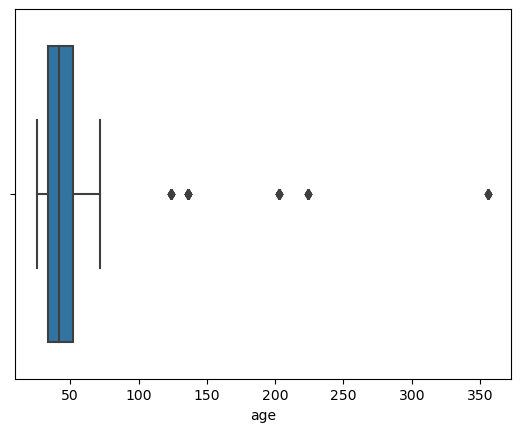

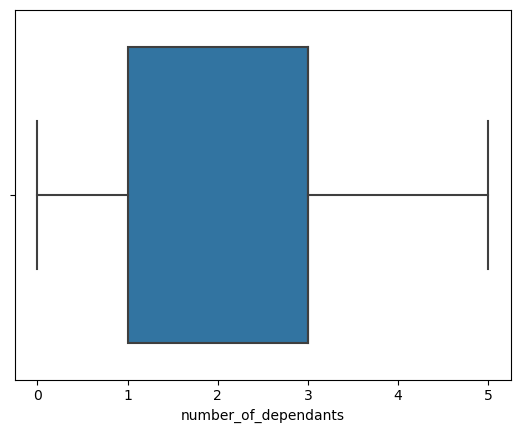

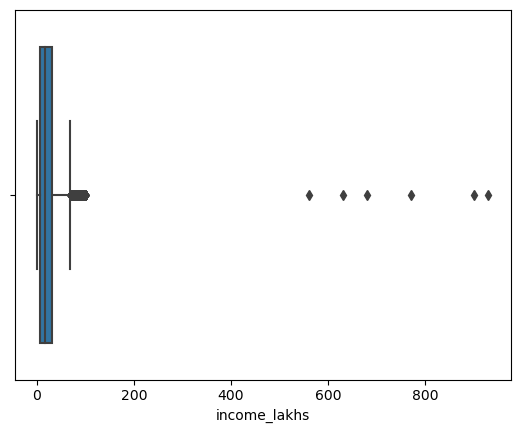

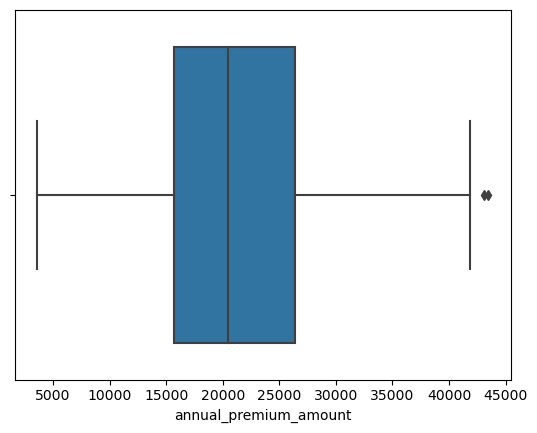

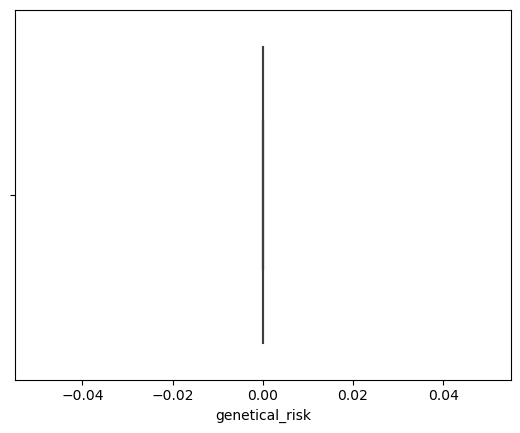

In [15]:
for col in numeric_columns:
    
    sns.boxplot(x=df[col])
    plt.show()

In [16]:
#check age
df[df.age > 100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [17]:
#Remove incorrect age of higher than 100
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


In [18]:
df1.income_lakhs.quantile([0.25,0.75])

0.25     7.0
0.75    32.0
Name: income_lakhs, dtype: float64

In [19]:
#dealing with outlier in income column

def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5* IQR
    return lower_bound, upper_bound

In [20]:
get_iqr_bounds(df1.income_lakhs)

(-30.5, 69.5)

67 lakhs is not that extream, so we do not want to remove it

In [21]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

100.0

In [22]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


<Axes: xlabel='income_lakhs', ylabel='Count'>

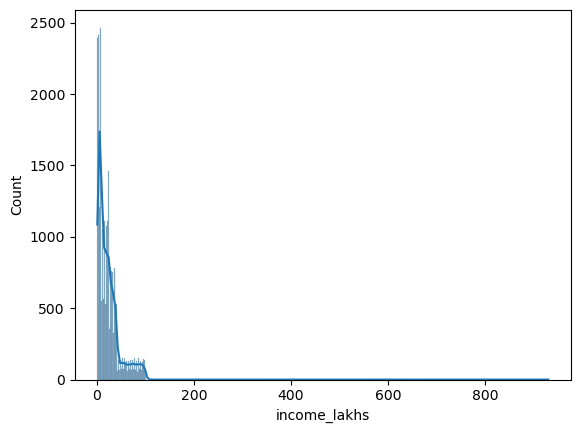

In [23]:
# with outlier
sns.histplot(df1['income_lakhs'], kde=True)

### EDA: Univariant Analysis

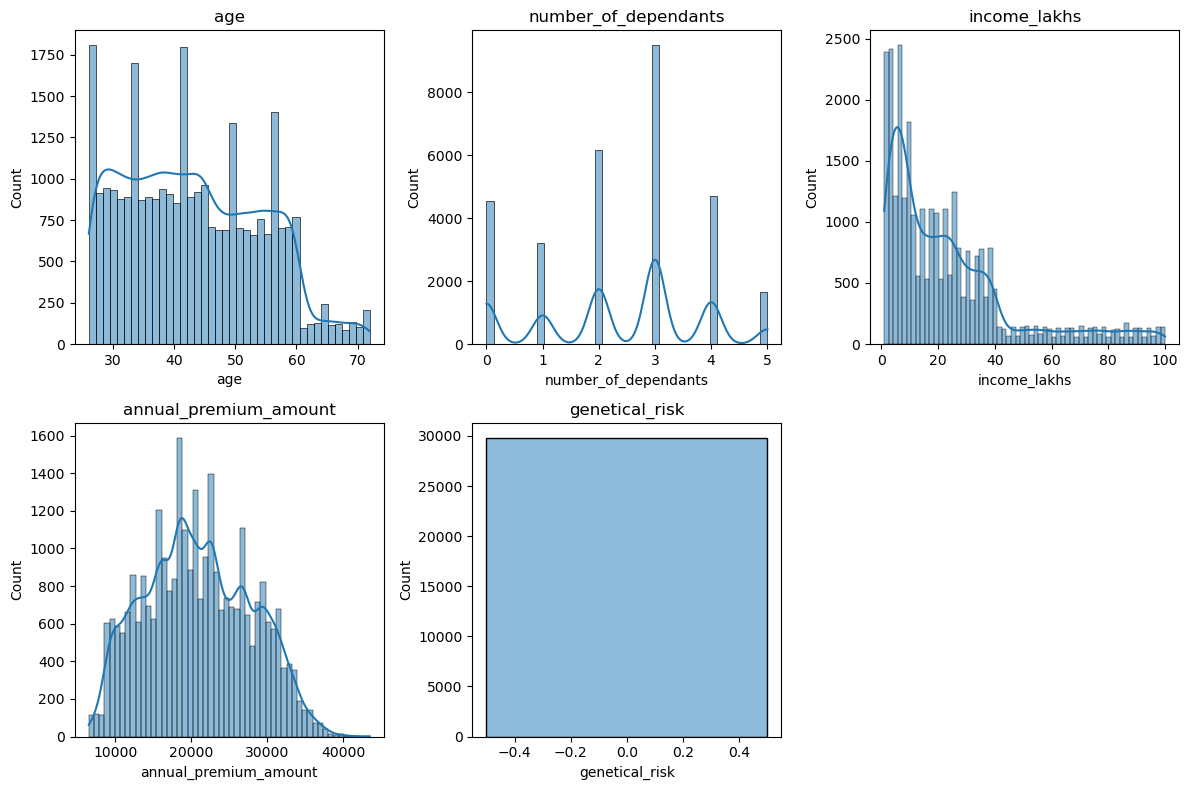

In [24]:
# without outlier
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # 2 rows, 3 columns for 5 plots
axs = axs.flatten()  # Flatten the 2D grid to easily access axes with a single index

for i, column in enumerate(numeric_columns[:5]):  # Only loop through the first 5 columns
    sns.histplot(df2[column], kde=True, ax=axs[i])  # Use axs[i] for each plot
    axs[i].set_title(column)

# Hide any unused subplots
for j in range(5, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### EDA: Bivariant Analysis

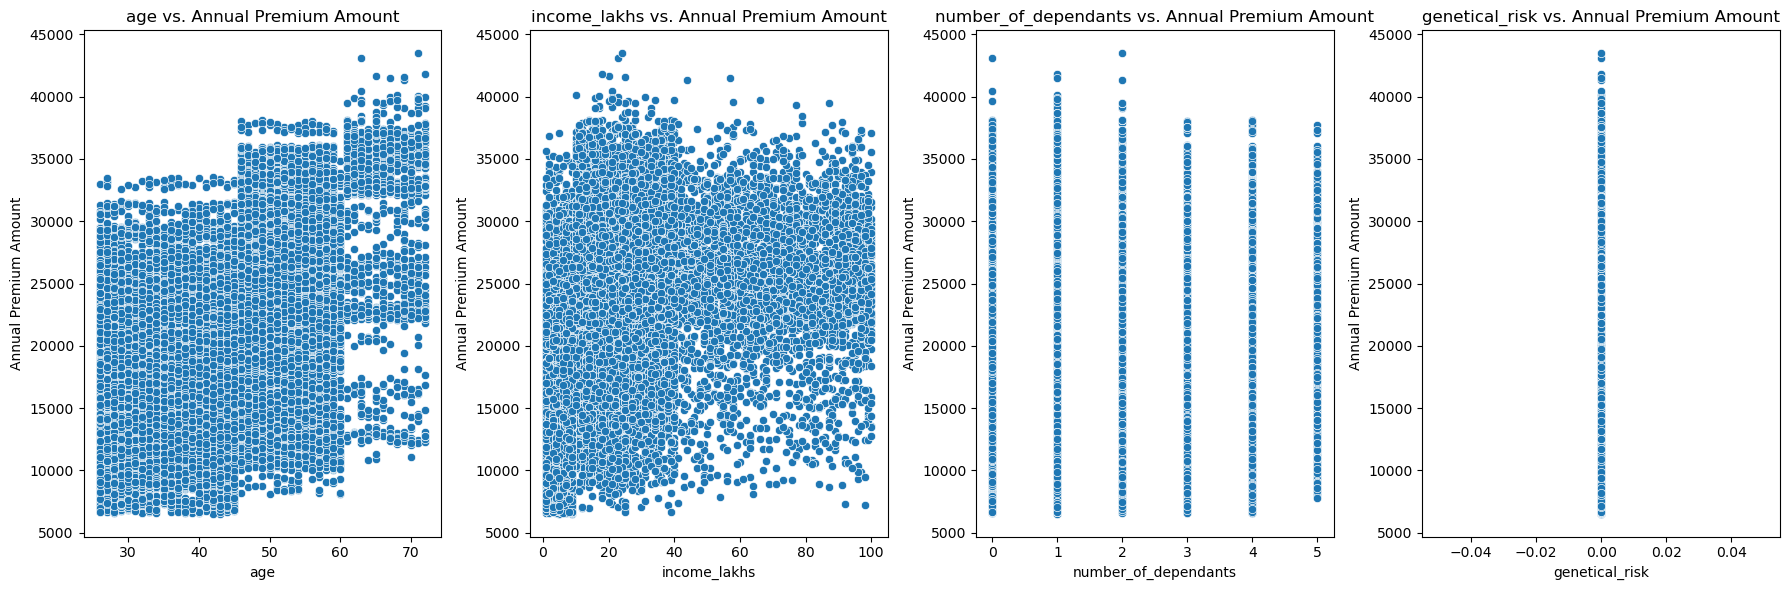

In [25]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants', 'genetical_risk']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

We can see that age increase, the annual premium is increasing, but for the other 2, we cannot see clear relationship

### EDA: Bivariate Analysis: Categorical data

In [26]:
categorical_cols = df.select_dtypes(['object']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [27]:
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [28]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking'
}, inplace=True)

df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [29]:
pct_count = df2['gender'].value_counts(normalize=True)
pct_count

gender
Male      0.549125
Female    0.450875
Name: proportion, dtype: float64

<Axes: xlabel='gender'>

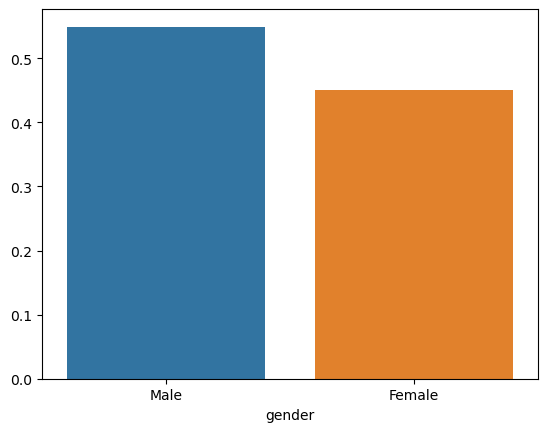

In [30]:
sns.barplot(x=pct_count.index, y=pct_count.values)

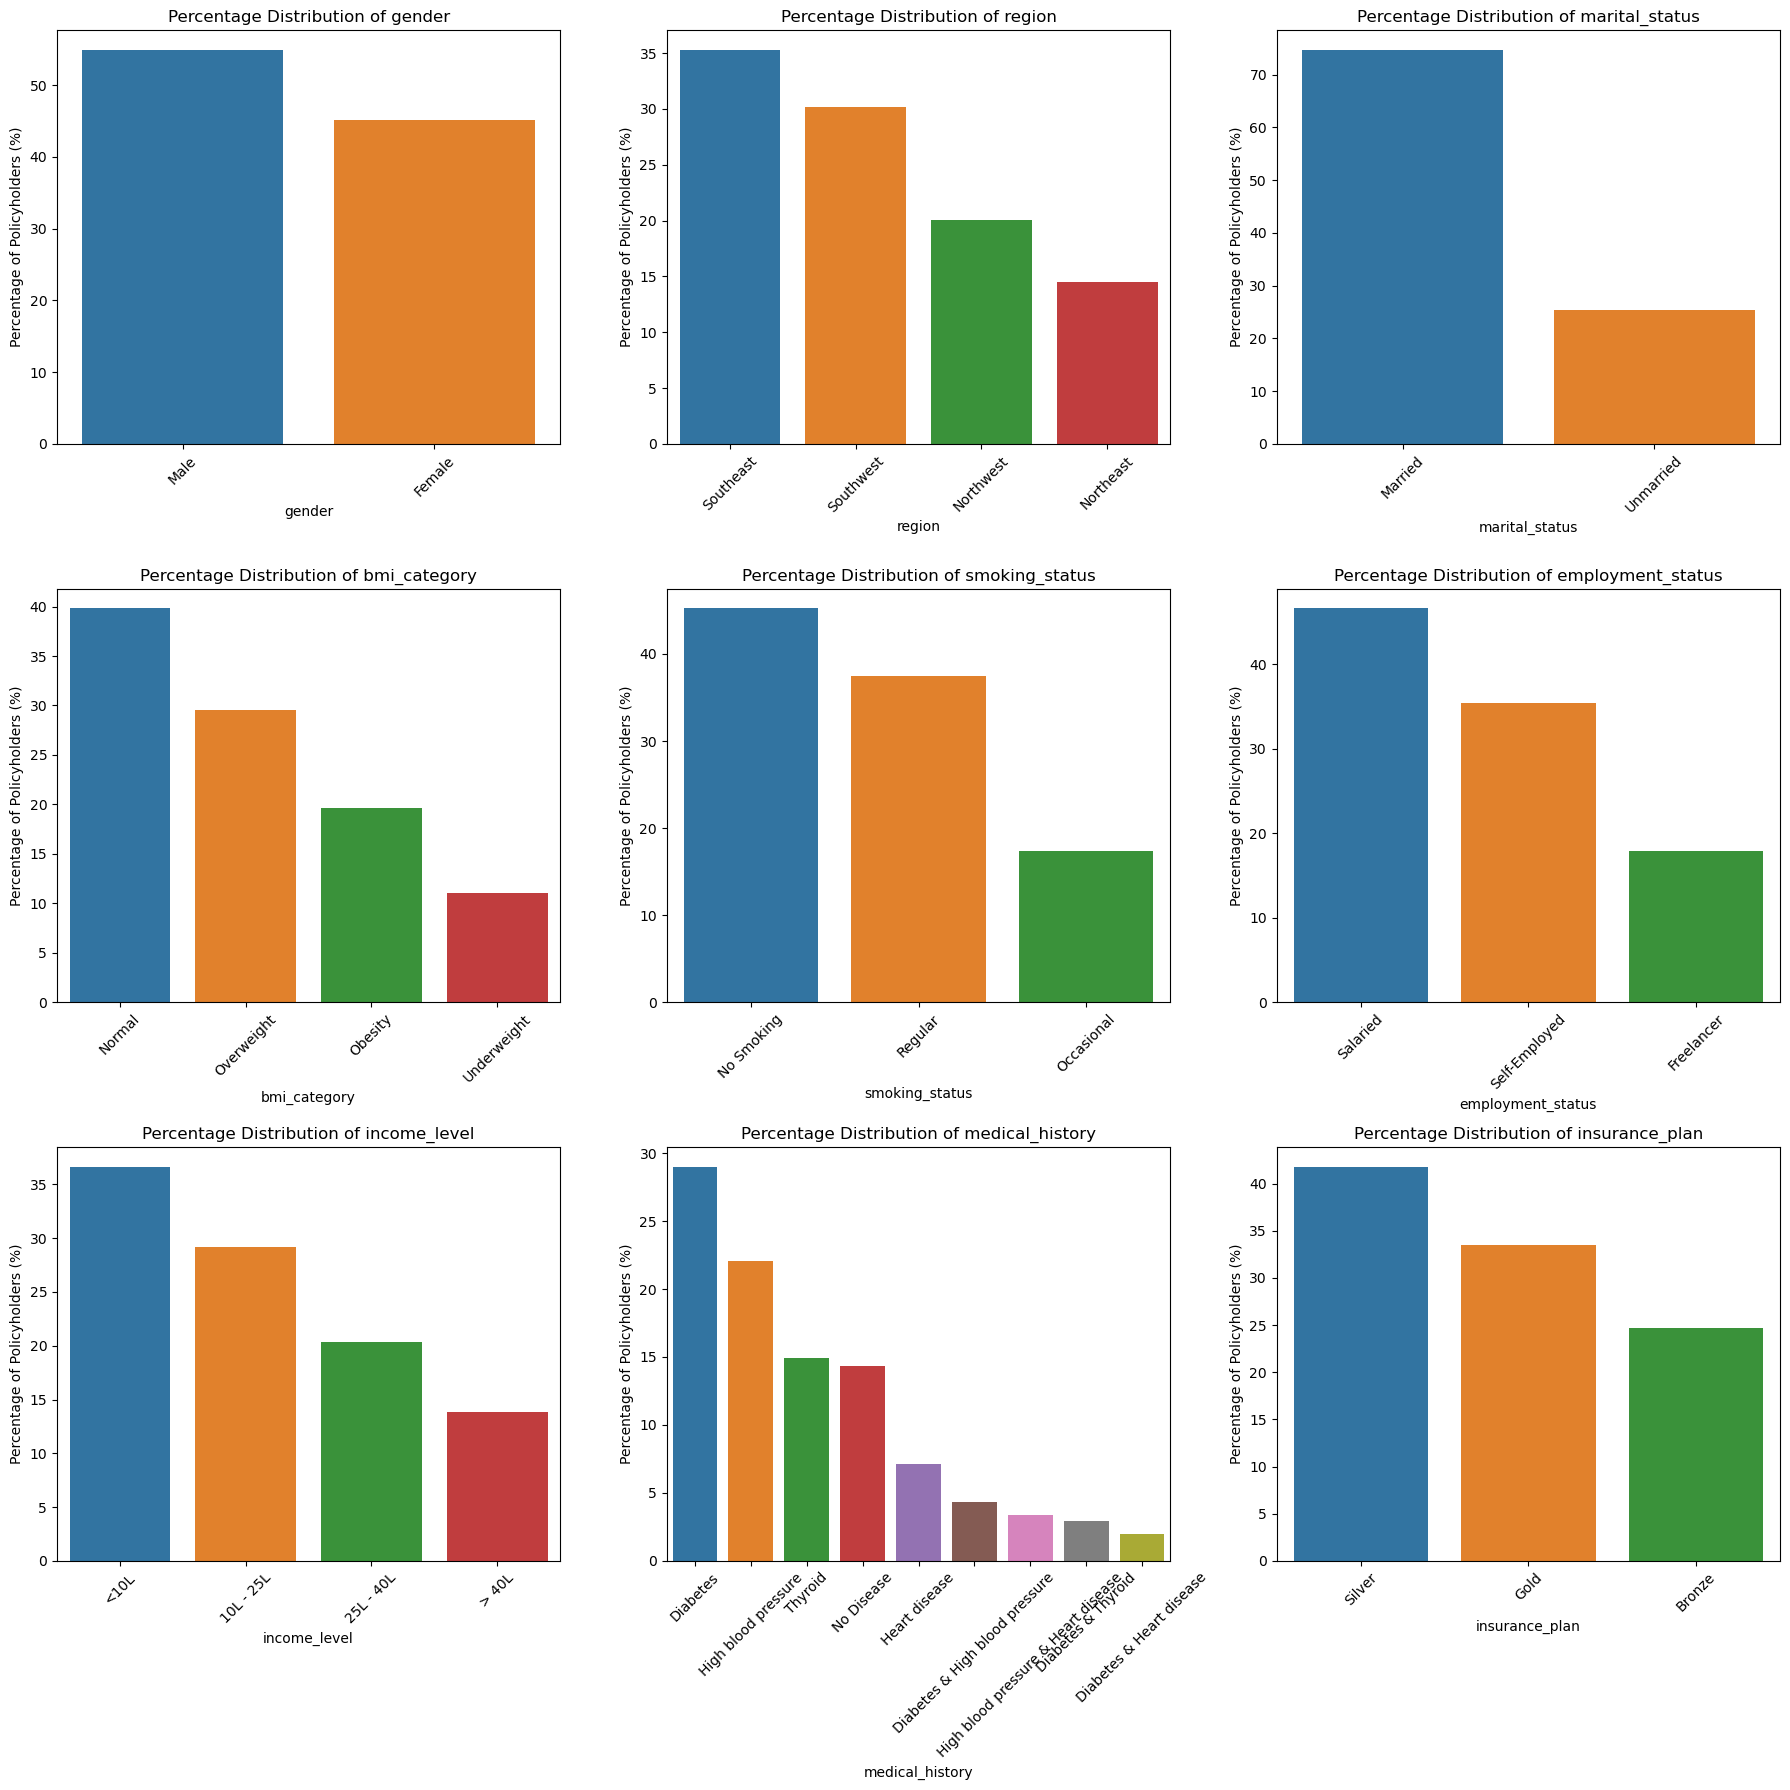

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df2[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity
    
    # Rotate the x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()


In [32]:
# income level vs insurance plane
cross_tap = pd.crosstab(df2['income_level'], df2['insurance_plan'])
cross_tap

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


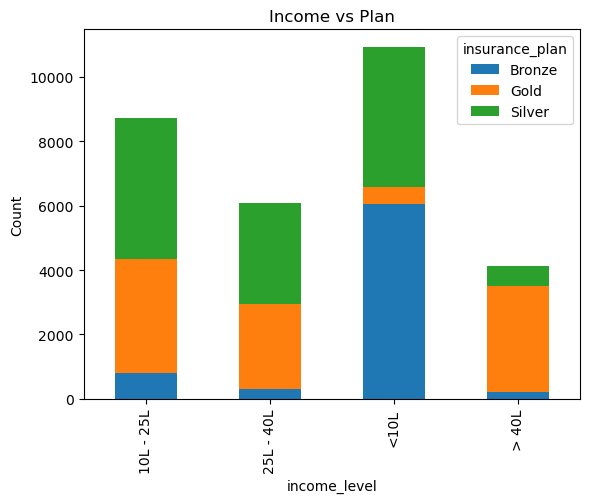

In [33]:
# Plotting the crosstab
cross_tap.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

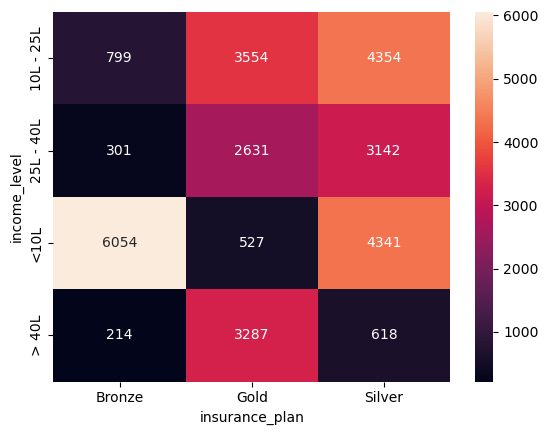

In [34]:
sns.heatmap(cross_tap, annot=True, fmt='d')
plt.show()

### Feature Engineering

In [35]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [36]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [37]:
# Define the risk scores for each condition, from business
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1','disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x:x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None


In [38]:
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1','disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)
    
# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571


In [39]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
26305,28,Male,Southwest,Unmarried,0,Overweight,Regular,Salaried,<10L,2,Diabetes,Bronze,13929,0,diabetes,none,6,0.428571
16606,35,Female,Southwest,Married,3,Obesity,Regular,Self-Employed,<10L,5,Diabetes & High blood pressure,Bronze,17643,0,diabetes,high blood pressure,12,0.857143
22290,36,Male,Northwest,Unmarried,2,Overweight,No Smoking,Self-Employed,> 40L,100,High blood pressure,Gold,23663,0,high blood pressure,none,6,0.428571
5731,37,Female,Southwest,Married,3,Normal,No Smoking,Salaried,<10L,8,Diabetes,Bronze,8622,0,diabetes,none,6,0.428571
14917,26,Female,Northeast,Unmarried,1,Overweight,Occasional,Salaried,<10L,8,High blood pressure,Bronze,12316,0,high blood pressure,none,6,0.428571
16329,57,Female,Southeast,Married,3,Normal,No Smoking,Self-Employed,10L - 25L,25,High blood pressure,Gold,26960,0,high blood pressure,none,6,0.428571
26300,32,Female,Southeast,Married,3,Obesity,No Smoking,Salaried,<10L,1,No Disease,Bronze,11541,0,no disease,none,0,0.000000
5075,31,Female,Northwest,Unmarried,1,Obesity,Regular,Salaried,10L - 25L,23,Diabetes,Gold,28951,0,diabetes,none,6,0.428571
3737,57,Female,Southwest,Married,3,Obesity,No Smoking,Self-Employed,25L - 40L,25,Thyroid,Gold,30214,0,thyroid,none,5,0.357143
19756,27,Male,Northeast,Married,2,Normal,Regular,Freelancer,10L - 25L,15,High blood pressure,Silver,18876,0,high blood pressure,none,6,0.428571


In [40]:
df2.insurance_plan.unique() #ordinal category

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [41]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2['insurance_plan'].unique()

array([1, 2, 3], dtype=int64)

In [42]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,0,high blood pressure,none,6,0.428571


In [43]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,high blood pressure,none,...,0,0,0,0,0,0,0,0,0,1


#### Feature Selection

In [44]:
df4 = df3.drop(['medical_history','disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


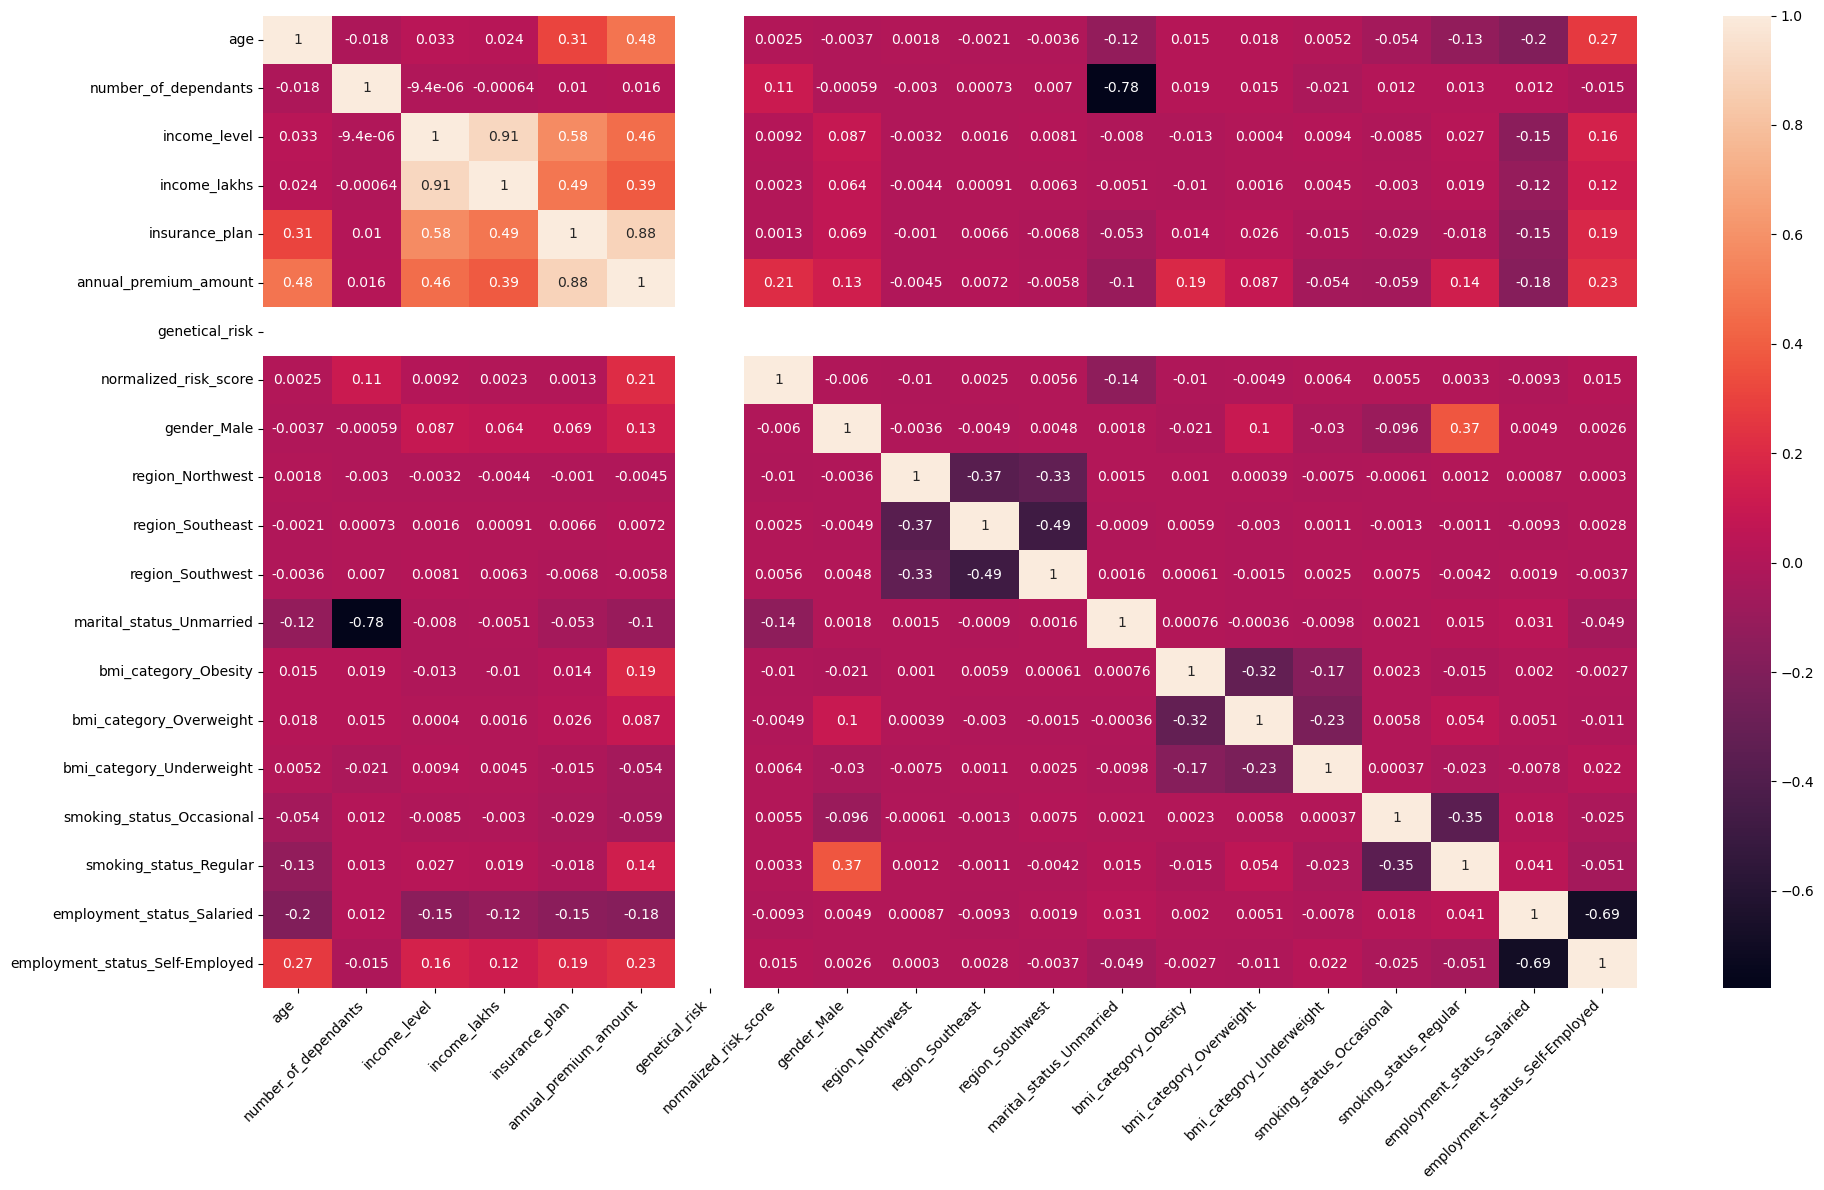

In [45]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


It is better to calculate VIF showing relationship of one feature to other features

In [47]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

# scaling before VIF
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [48]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
#Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [50]:
calculate_vif(X)

C:\Users\siril\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,genetical_risk,NaN
6,normalized_risk_score,3.810619
7,gender_Male,2.599098
8,region_Northwest,2.123965
9,region_Southeast,2.980842


From correlation metric, income_level and income_lakhs has high correlation, which we will normally drop 1 from it

In [51]:
#drop column with highest VIF between income_level and income lakhs

calculate_vif(X.drop('income_level', axis=1))

C:\Users\siril\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,normalized_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


**Good Practice to drop feature one by one and see**

In [52]:
X_reduced = X.drop('income_level', axis=1)
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Model Training

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (20875, 18)
x test:  (8947, 18)
y train:  (20875,)
y test:  (8947,)


#### Model Training: Linear Regression

In [54]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

(0.9534163989489616, 0.9538448451629948)

In [55]:
y_pred = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  2183844.360312458 RMSE:  1477.783597253826


In [56]:
X_test.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
19713,0.652174,0.0,0.262626,1.0,0.0,0.428571,0,0,0,1,1,0,0,0,0,0,0,1
14750,0.000000,0.8,0.101010,0.5,0.0,1.000000,0,0,0,1,0,0,0,1,0,1,1,0
19932,0.652174,0.0,0.040404,0.5,0.0,0.428571,1,0,1,0,1,0,0,0,0,1,1,0
29643,0.000000,0.6,0.020202,0.0,0.0,0.428571,0,0,0,1,0,0,0,0,0,0,1,0
17076,0.695652,1.0,0.323232,1.0,0.0,0.357143,0,0,0,1,0,0,0,0,0,0,0,1


In [57]:
model_lr.intercept_

5935.981289344416

In [58]:
model_lr.coef_

array([ 7.01623933e+03, -1.31176470e+03, -7.08193369e+02,  1.48359882e+04,
        3.18323146e-12,  6.05362412e+03,  3.75582688e+01, -5.52508721e+01,
       -1.96225429e+01, -2.22896756e+01, -7.00320200e+02,  3.92681271e+03,
        1.97945605e+03,  6.12866236e+02,  8.37395101e+02,  2.80066184e+03,
       -4.54913671e+01,  2.43078421e+02])

In [59]:

feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, columns=["Coefficients"], index=X_test.columns)
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)
coef_df

,Coefficients
number_of_dependants,-1.311765e+03
income_lakhs,-7.081934e+02
marital_status_Unmarried,-7.003202e+02
region_Northwest,-5.525087e+01
employment_status_Salaried,-4.549137e+01
region_Southwest,-2.228968e+01
region_Southeast,-1.962254e+01
genetical_risk,3.183231e-12
gender_Male,3.755827e+01
employment_status_Self-Employed,2.430784e+02


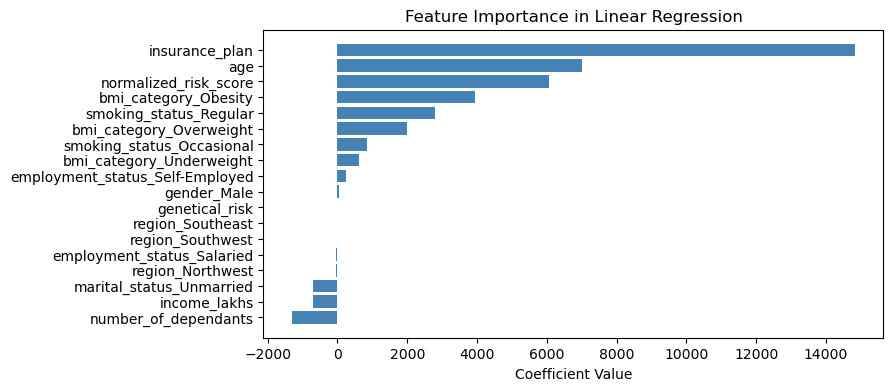

In [60]:
# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

#### Model Training: Ridge

In [61]:
model_rg = Ridge(alpha=10)
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9534000354275609, 0.9538387998701963)

#### Model Training: XGBoost

In [62]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9986370801925659, 0.9979538321495056)

In [63]:
y_pred = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression ==> MSE: ", mse_xgb, "RMSE: ", rmse_xgb)

XGBoost Regression ==> MSE:  96814.21540071907 RMSE:  311.14982789762087


#### GridSerchCV

In [64]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

0.9970577955245972

The accuracy above is r^2

In [65]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [66]:
best_model = random_search.best_estimator_

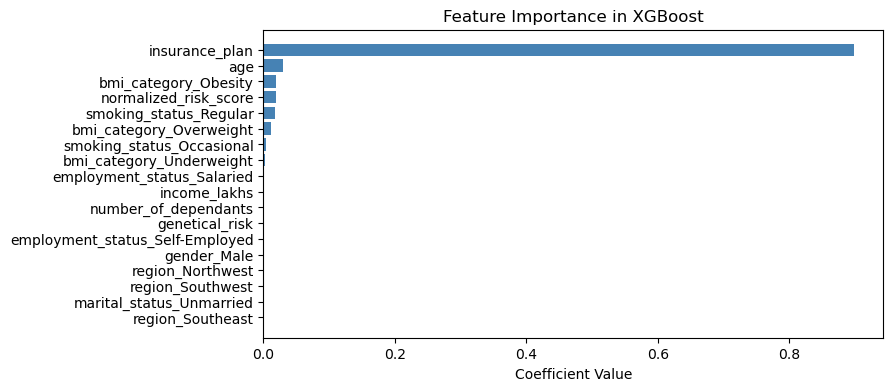

In [67]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, columns=["Coefficients"], index=X_test.columns)
coef_df = coef_df.sort_values(by="Coefficients", ascending=True)
coef_df

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

For explanability, feature importance in Linear is better interpretation

### Error Analysis

In [68]:
y_pred = best_model.predict(X_test)

residuals =  y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
19713,26895,26691.470703,-203.529297,-0.756755
14750,22734,22650.751953,-83.248047,-0.366183
19932,21198,21581.894531,383.894531,1.810994
29643,9100,9425.934570,325.934570,3.581699
17076,26434,26691.470703,257.470703,0.974013


<Axes: xlabel='diff_pct', ylabel='Count'>

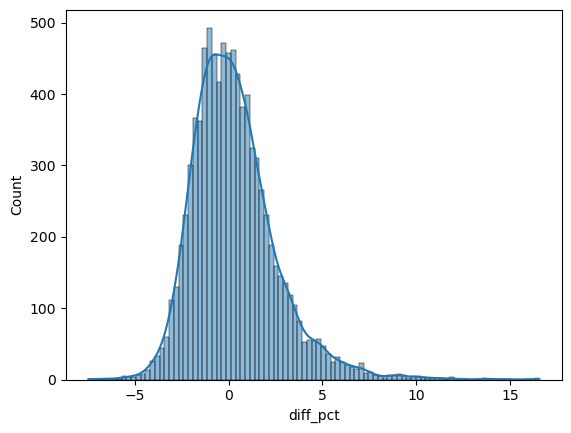

In [69]:
sns.histplot(results_df['diff_pct'], kde=True)

There are many point that have very high error, so we need to decide the treshold. The error should not exceed 10%

In [70]:
extreme_error_threshold = 10 
extreme_result_df = results_df[np.abs(results_df.diff_pct) > extreme_error_threshold]
extreme_result_df.shape

(29, 4)

In [71]:
results_df.shape

(8947, 4)

In [72]:
extreme_error_pct = extreme_result_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.32413099362914943

In [73]:
results_df[np.abs(results_df.diff_pct) > 50].sort_values(by = 'diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


So from above, we cannot deploy models because there are many prediction with high margin error. 

In [74]:
extreme_result_df.head()

,actual,predicted,diff,diff_pct
14286,6845,7621.263672,776.263672,11.340594
27518,8502,9425.934570,923.934570,10.867261
9285,6872,7621.263672,749.263672,10.903138
7547,6538,7621.263672,1083.263672,16.568732
21910,6651,7621.263672,970.263672,14.588237


In [75]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan',
 'genetical_risk']

### Export the model

In [76]:
from joblib import dump

dump(best_model, "artifacts/model_rest.joblib")

scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

dump(scaler_with_cols, "artifacts/scaler_rest.joblib")

['artifacts/scaler_rest.joblib']